The purpose of this script is to compute and store the data 
necessary to estimate the relative probability of insertion of L1 elements in various known human tumor suppressor genes (TSGs). The analysis is based on the Snap-Velcro model of Monot et al. 2013. The hg38 
reference genome is used.

In [1]:
#--- Load necessary libraries
library(data.table)
library(BSgenome.Hsapiens.UCSC.hg38)
library(GenomicRanges)
library(GenomicFeatures)
library(plyr)`o
library(mixtools)
options(warn=1) # print any warnings
colscheme = c("deeppink","darkgreen","dodgerblue","grey")

Loading required package: BSgenome
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, grep, grepl,
    intersect, is.unsorted, lapply, lengths, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unlist, unsplit

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: IRanges

Atta

## Check for ./tsg_annotation.rda

In [2]:
if(file.exists("./tsg_annotation.rda")) {
    cat("TSG annotation data file exists, skip to Analysis\n")
} else {
    cat("TSG annotation must be created")
}

TSG annotation data file exists, skip to Analysis


## If not found, create it with the following code, else skip to Analysis

A tab-delimited file is read from the web to a table. The file is made available by the TSGene 2.0 database project and contains data on 983 human tumor suppressor genes which are down-regulated in tumor samples versus normal tissue.

In [3]:
tsg_table <- fread("https://bioinfo.uth.edu/TSGene/All_down_exp_TSGs_pan-cancer.txt")
cat("Sample:")
head(tsg_table)

Sample:

GeneID,GeneName,NumberOfCancers,CancerTypes
9590,AKAP12,11,"COAD,THCA,KICH,BLCA,KIRC,UCEC,HNSC,PRAD,LUSC,LUAD,BRCA,"
8854,ALDH1A2,11,"COAD,THCA,KICH,BLCA,KIRC,UCEC,HNSC,PRAD,LUSC,LUAD,BRCA,"
84417,C2orf40,11,"COAD,THCA,KICH,BLCA,KIRC,UCEC,HNSC,PRAD,LUSC,LUAD,BRCA,"
8434,RECK,11,"COAD,THCA,KICH,BLCA,KIRC,UCEC,HNSC,PRAD,LUSC,LUAD,BRCA,"
8031,NCOA4,11,"COAD,THCA,KICH,BLCA,KIRC,UCEC,HNSC,PRAD,LUSC,LUAD,BRCA,"
79633,FAT4,11,"COAD,THCA,KICH,BLCA,KIRC,UCEC,HNSC,PRAD,LUSC,LUAD,BRCA,"


A GFF3 file for hg38, which is stored locally, is called, and the entries describing genes are read into a table.

In [4]:
system(paste0("grep ID=gene ../Data/humangenome/Homo_sapiens.GRCh38.89.gff3 > tmp"))
geneann <- fread("tmp") # extract all lines from .gff3 describing genes into a table
system("rm tmp")
cat("Gene list from hg38 .gff3 file")
names(geneann) <- c('chrom','source','type','start','end','score','strand','phase','attributes')
head(geneann)

Gene list from hg38 .gff3 file

chrom,source,type,start,end,score,strand,phase,attributes
1,havana,gene,11869,14409,.,+,.,ID=gene:ENSG00000223972;Name=DDX11L1;biotype=transcribed_unprocessed_pseudogene;description=DEAD/H-box helicase 11 like 1 [Source:HGNC Symbol%3BAcc:HGNC:37102];gene_id=ENSG00000223972;logic_name=havana;version=5
1,havana,gene,14404,29570,.,-,.,ID=gene:ENSG00000227232;Name=WASH7P;biotype=unprocessed_pseudogene;description=WAS protein family homolog 7 pseudogene [Source:HGNC Symbol%3BAcc:HGNC:38034];gene_id=ENSG00000227232;logic_name=havana;version=5
1,mirbase,miRNA_gene,17369,17436,.,-,.,ID=gene:ENSG00000278267;Name=MIR6859-1;biotype=miRNA;description=microRNA 6859-1 [Source:HGNC Symbol%3BAcc:HGNC:50039];gene_id=ENSG00000278267;logic_name=ncrna;version=1
1,havana,lincRNA_gene,29554,31109,.,+,.,ID=gene:ENSG00000243485;Name=MIR1302-2HG;biotype=lincRNA;description=MIR1302-2 host gene [Source:HGNC Symbol%3BAcc:HGNC:52482];gene_id=ENSG00000243485;logic_name=havana;version=5
1,mirbase,miRNA_gene,30366,30503,.,+,.,ID=gene:ENSG00000284332;Name=MIR1302-2;biotype=miRNA;description=microRNA 1302-2 [Source:HGNC Symbol%3BAcc:HGNC:35294];gene_id=ENSG00000284332;logic_name=ncrna;version=1
1,havana,lincRNA_gene,34554,36081,.,-,.,ID=gene:ENSG00000237613;Name=FAM138A;biotype=lincRNA;description=family with sequence similarity 138 member A [Source:HGNC Symbol%3BAcc:HGNC:32334];gene_id=ENSG00000237613;logic_name=havana;version=2


Next, we filter through the gene annotations, storing those describing TSGs from the TSGene 2.0 list.

In [5]:
j=1;
tsg_inds<-rep(0,nrow(tsg_table)) # allocate memory for array of TSG indices in the list of genes
for (i in tsg_table$GeneName){
        tmp <- grep(paste0("Name=",i,";"),geneann$attributes) # search for "Name=<gene name>" in the attributes column of the .gff3
        if (length(tmp)==0){ # if it was not found, place a NA for index of the current TSG
                tsg_inds[j]=NA;
        } else { # if found, store its index in the list
                tsg_inds[j] <- tmp
        }
        j<-j+1 # increment tsg_inds array counter
        # print(grep(paste0("Name=",i,";"),geneann$V9)) # print to screen the index of the current TSG (not necessary)
}
tsgann <- geneann[tsg_inds] # extract rows of the geneann table associated with TSGs
tsgann <- tsgann[,c("chrom","start","end")] # extract columns describing genomic ranges (chrom name, start, end)

In [ ]:
tsgann$tsg_name <- tsg_table$GeneName # add gene names to the table
tsgann=tsgann[which(!is.na(tsgann$chrom))] # remove entries from the table which were not found in the GFF3
tsg_len = tsgann$end- tsgann$start
tsgann$length <- tsg_len # add a column for gene length
tsgann = tsgann[order(-tsg_len)] # order the rows of the table by gene length (longest gene in top entry)
head(tsgann)
cat(paste0(nrow(tsgann),"/",nrow(tsg_table)," TSGs from the database were located in hg38.\n"))

Get the gene sequences. Notice that they are ordered by length.

In [ ]:
gr <- GRanges(paste0("chr",tsgann$chrom),IRanges(tsgann$start,tsgann$end))
tsgs <- getSeq(Hsapiens,gr)
tsgs

Loop over the list of TSGs. For each, count the number of endonuclease sites for each Snap-Velcro category. This is done using the locally stored function 'mapSeq_SV.r'. The counts are appended to the TSG annotation table as columns.

In [27]:
source("../dev/mapSeq_SV.r")
tsg_counts <-  array(0,dim=c(nrow(tsgann),4)) # Allocate memory
for (i in 1:nrow(tsgann)){
    tmp <- mapSeq_SV(tsgs[[i]])
    tsg_counts[i,]=c(length(which(!is.na(tmp$ict))),length(which(!is.na(tmp$icl))),length(which(!is.na(tmp$iot))),length(which(!is.na(tmp$iol))))
}
tsgann <- cbind(tsgann,tsg_counts)
rownames(tsg_counts) <- tsgann$tsg_name

In [ ]:
names(tsgann)[6:9]=c("CT","CL","OT","OL")
head(tsgann)

In [ ]:
save(tsgann,tsg_counts,tsgs,file="./tsg_annotation.rda")

Next, we plot the total number of endonuclease sites for the 100 longest TSGs.

## Analysis 1 - All endonuclease sites are considered

In [2]:
load("./tsg_annotation.rda")

tsg_EN_den = rowSums(tsg_counts)/tsgann$length # calculate density of EN sites of each TSG
rownames(tsg_counts) <- tsgann$tsg_name

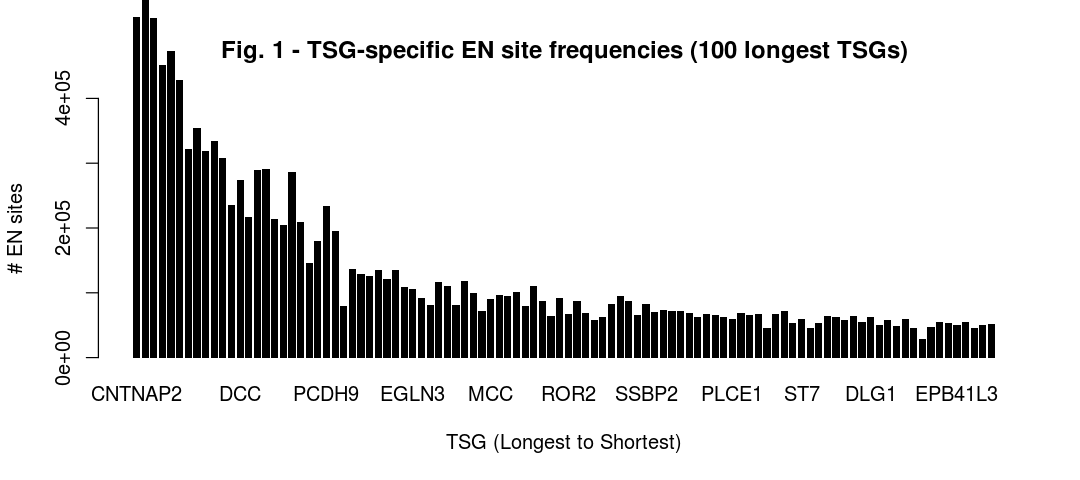

In [21]:
barplot(t(tsg_counts[1:100,1:4]),col=c("black","black","black","black"),ylab="# EN sites",xlab="TSG (Longest to Shortest)",border=NA,beside=FALSE,ylim=c(0,400000))
title("Fig. 1 - TSG-specific EN site frequencies (100 longest TSGs)")
options(repr.plot.width=9, repr.plot.height=4)

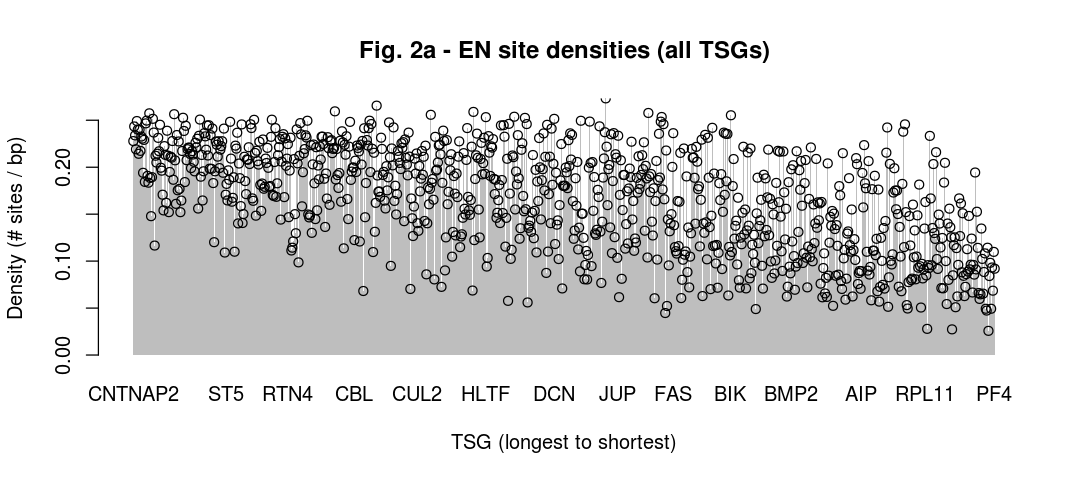

In [4]:
bar <- barplot(tsg_EN_den,ylab="Density (# sites / bp)",xlab="TSG (longest to shortest)",col="grey",border=NA,space=0)
title("Fig. 2a - EN site densities (all TSGs)")
points(x=bar,tsg_EN_den)
options(repr.plot.width=8, repr.plot.height=4)

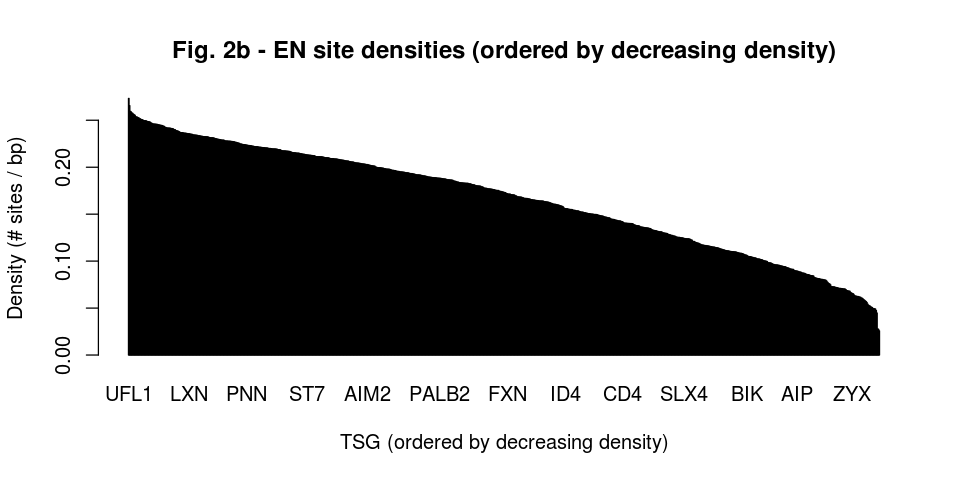

In [5]:
barplot(tsg_EN_den[order(-tsg_EN_den)],ylab="Density (# sites / bp)",xlab="TSG (ordered by decreasing density)",col="black")
title("Fig. 2b - EN site densities (ordered by decreasing density)")
options(repr.plot.width=8, repr.plot.height=4)

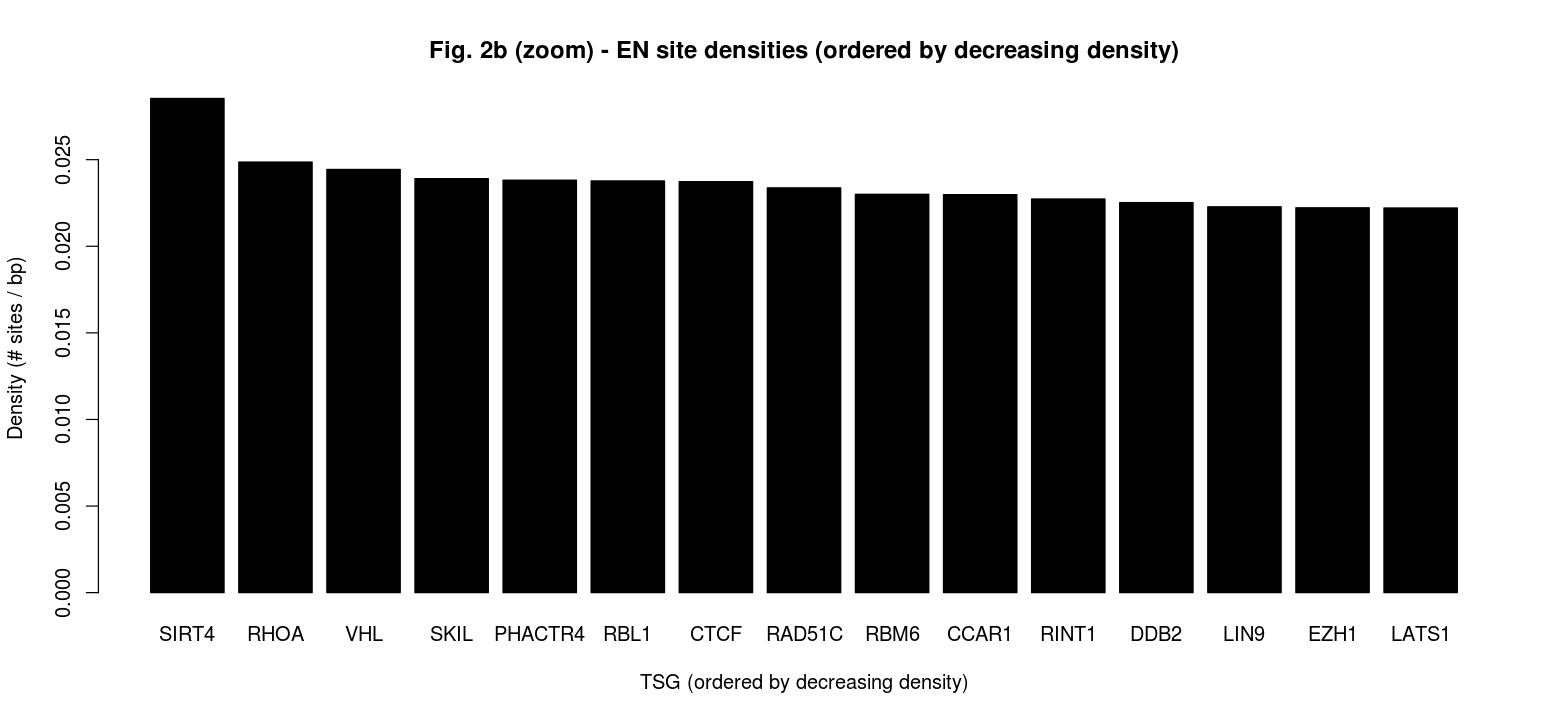

In [26]:
tmp <-tsg_EN_den[order(-tsg_EN_den)]

barplot(tmp[1:15],ylab="Density (# sites / bp)",xlab="TSG (ordered by decreasing density)",col="black")
title("Fig. 2b (zoom) - EN site densities (ordered by decreasing density)")
options(repr.plot.width=13, repr.plot.height=6)

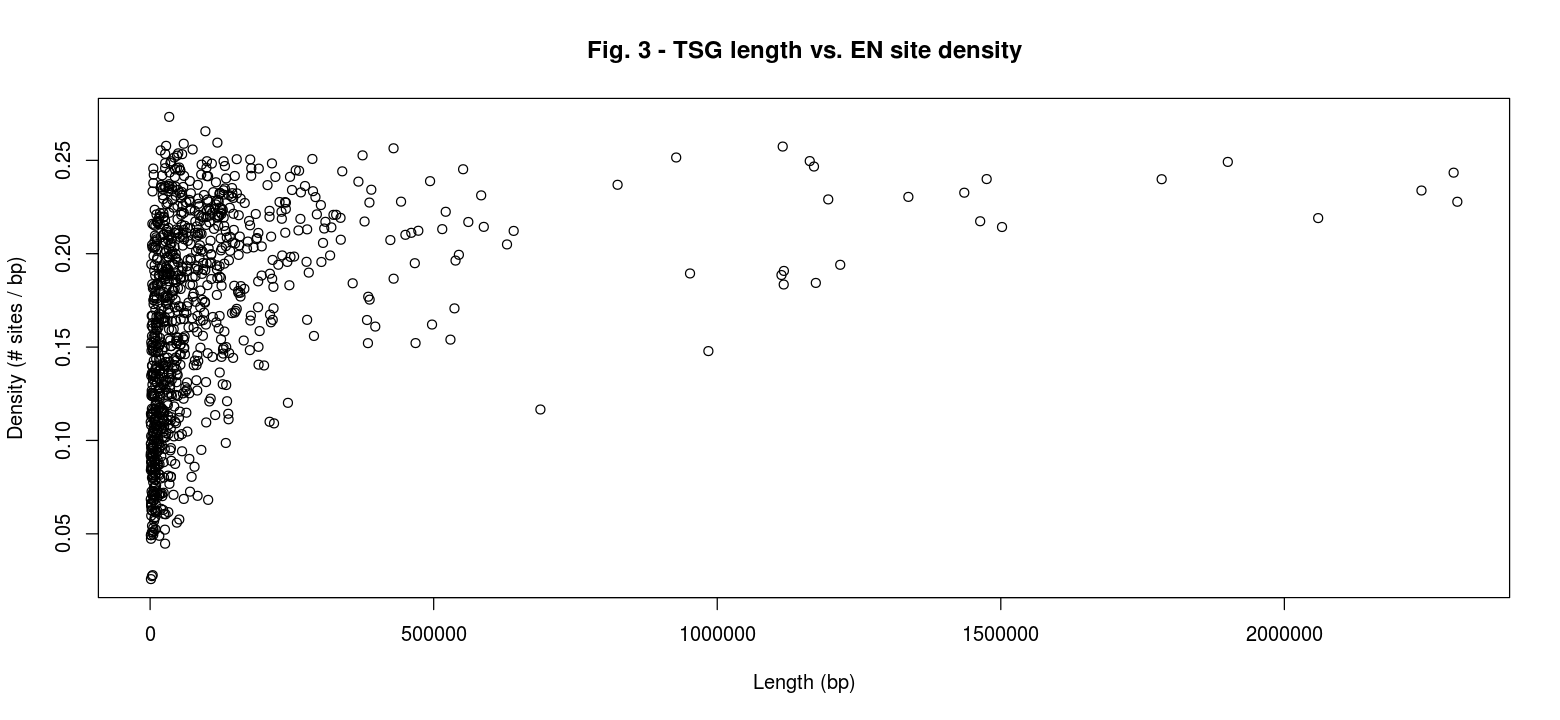

In [7]:
plot(tsgann$length,tsg_EN_den,ylab="Density (# sites / bp)",xlab="Length (bp)")
title("Fig. 3 - TSG length vs. EN site density")
options(repr.plot.width=8, repr.plot.height=4)

Several TSGs are much longer than the others, with a high density of EN sites (upper right corner). We print six TSGs with the highest number of sites below.

In [8]:
nsites <- rowSums(tsg_counts)
tmp <- nsites[1:6]
tmp[order(-tmp)]

PTPRD CNTNAP2     DMD   LRP1B   CSMD1  CTNNA3 
 559459  525141  524219  473487  451218  427890

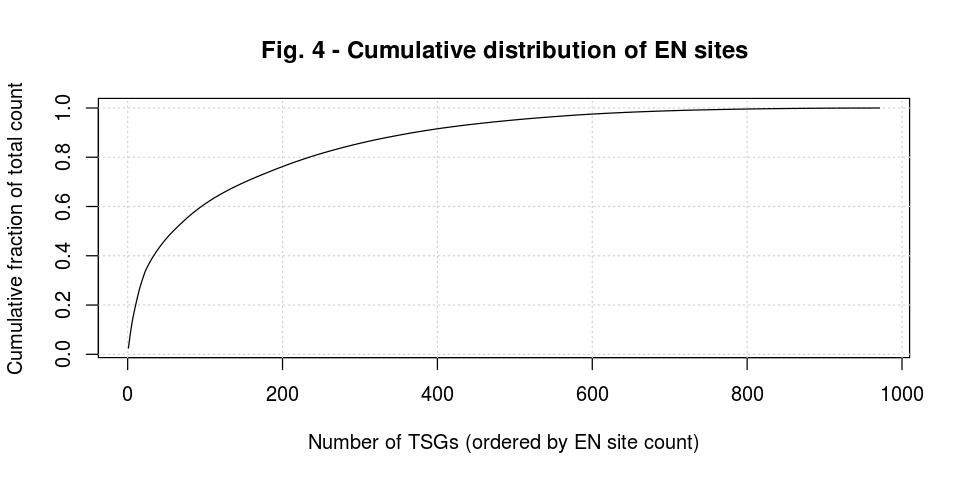

In [9]:
fracOfTotalSites <- nsites/sum(nsites)
fracOfTotalSites <- fracOfTotalSites[order(-fracOfTotalSites)]
cumuSum <- cumsum(fracOfTotalSites)
options(repr.plot.width=8, repr.plot.height=4)
plot(cumuSum,type="n",xlab="Number of TSGs (ordered by EN site count)",ylab="Cumulative fraction of total count")
grid()
lines(cumuSum)
title("Fig. 4 - Cumulative distribution of EN sites")

## Analysis 2 - Only 'closed-tight' sites considered

In [2]:
load("./tsg_annotation.rda")

tsg_EN_den = tsg_counts[,1]/tsgann$length # calculate density of closed-tight sites of each TSG
rownames(tsg_counts) <- tsgann$tsg_name

In [12]:
tsg_counts<-tsg_counts[order(-tsgann$CT),]
#tsg_counts <- tsg_counts[order(-tsgann$CT)]


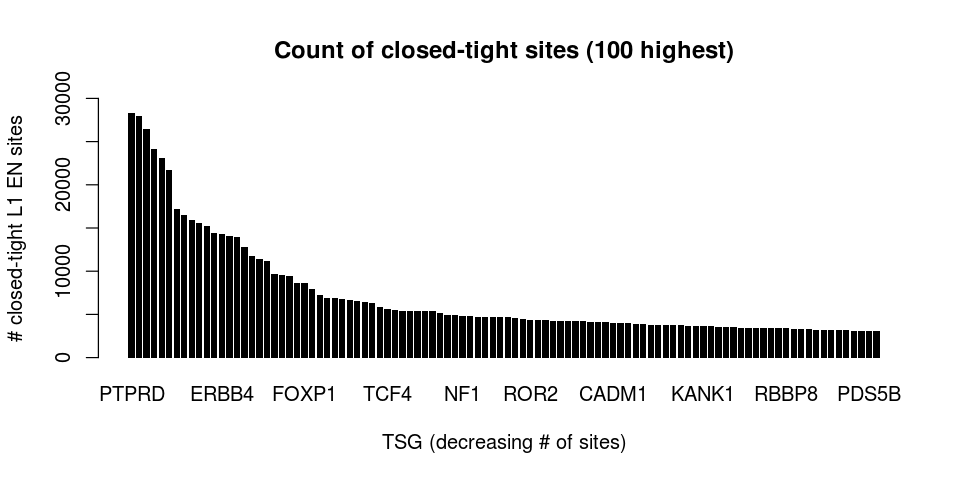

In [139]:
barplot(t(tsg_counts[1:100,1]),col="black",ylab="# closed-tight L1 EN sites",xlab="TSG (decreasing # of sites)",border=NA,ylim=c(0,30000))
title("Count of closed-tight sites (100 highest)")
options(repr.plot.width=8, repr.plot.height=4)

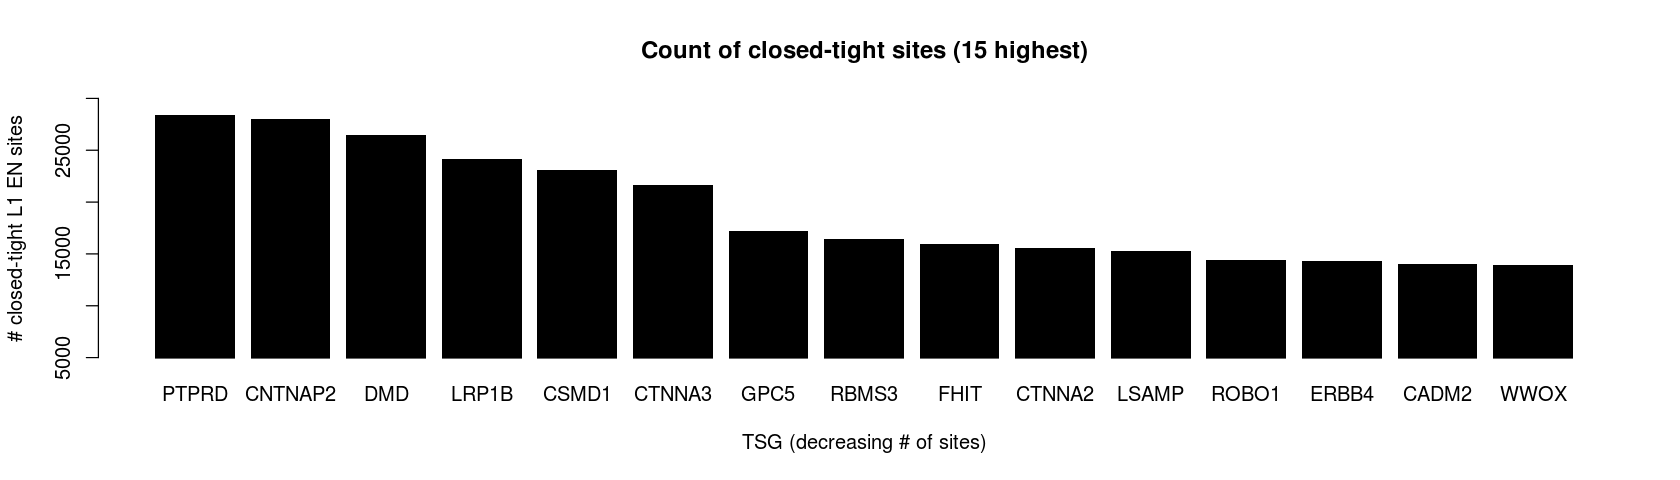

In [70]:
barplot(t(tsg_counts[1:15,1]),col="black",ylab="# closed-tight L1 EN sites",xlab="TSG (decreasing # of sites)",border=NA,ylim=c(5000,30000),xpd=FALSE)
title("Count of closed-tight sites (15 highest)")
options(repr.plot.width=14, repr.plot.height=4)

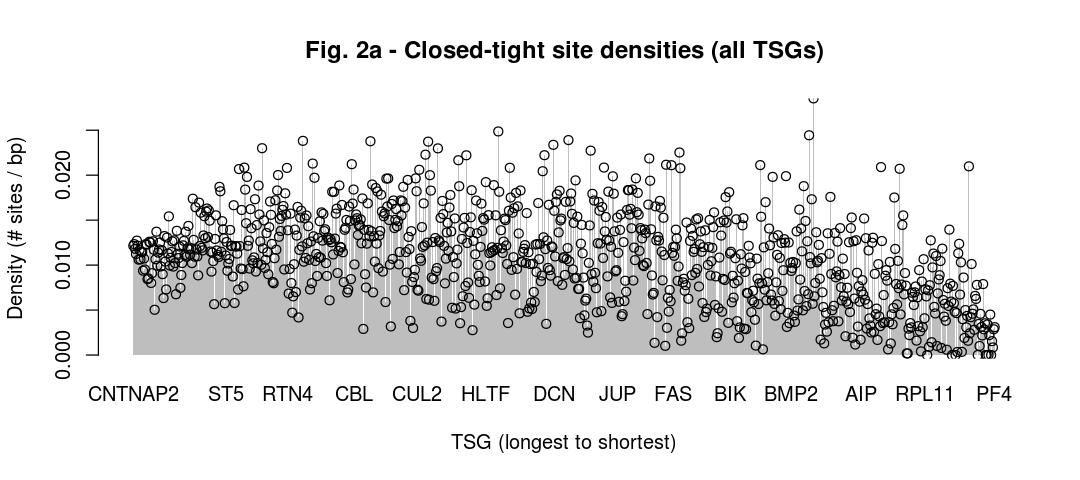

In [12]:
bar <- barplot(tsg_EN_den,ylab="Density (# sites / bp)",xlab="TSG (longest to shortest)",col="grey",border=NA,space=0)
title("Fig. 2a - Closed-tight site densities (all TSGs)")
points(x=bar,tsg_EN_den)
options(repr.plot.width=8, repr.plot.height=4)

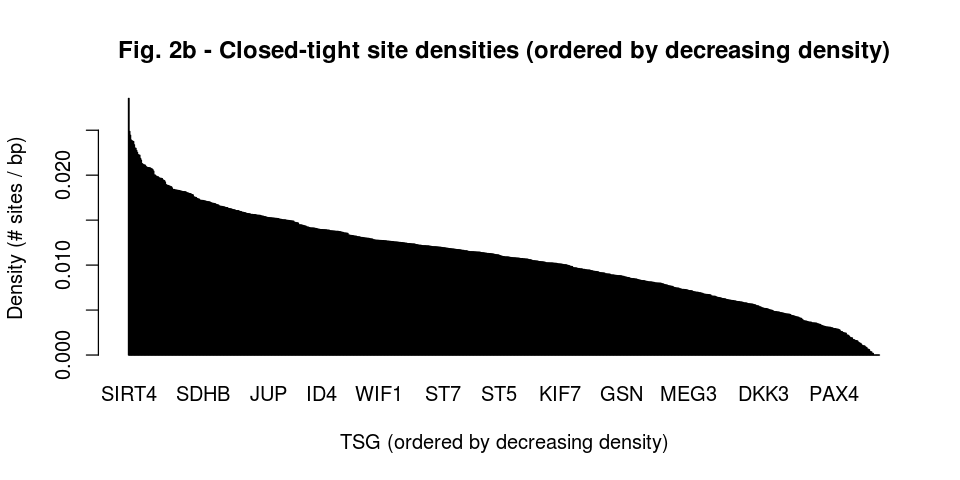

In [13]:
barplot(tsg_EN_den[order(-tsg_EN_den)],ylab="Density (# sites / bp)",xlab="TSG (ordered by decreasing density)",col="black")
title("Fig. 2b - Closed-tight site densities (ordered by decreasing density)")
options(repr.plot.width=8, repr.plot.height=4)

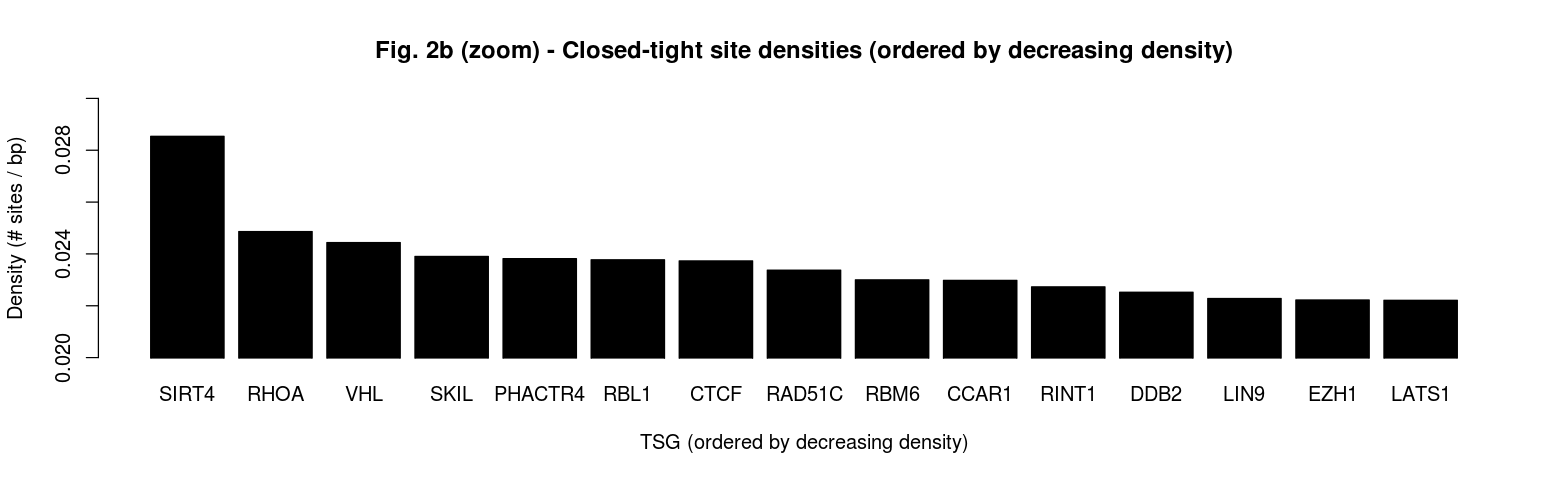

In [46]:
tmp <- tsg_EN_den[order(-tsg_EN_den)]

barplot(tmp[1:15],ylab="Density (# sites / bp)",xlab="TSG (ordered by decreasing density)",col="black",ylim=c(.02,.03),xpd=FALSE)
title("Fig. 2b (zoom) - Closed-tight site densities (ordered by decreasing density)")
options(repr.plot.width=13, repr.plot.height=4)

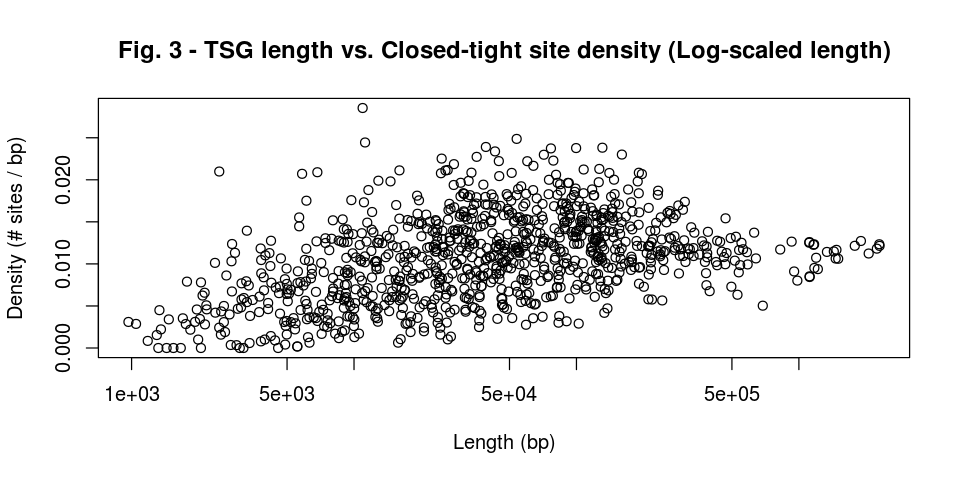

In [56]:
plot(tsgann$length,tsg_EN_den,ylab="Density (# sites / bp)",xlab="Length (bp)",log='x')
title("Fig. 3 - TSG length vs. Closed-tight site density (Log-scaled length)")
options(repr.plot.width=8, repr.plot.height=4)

In [4]:
nsites <- tsg_counts[,1]
tmp <- nsites[1:6]
tmp[order(-tmp)]

PTPRD CNTNAP2     DMD   LRP1B   CSMD1  CTNNA3 
  28352   27991   26482   24179   23141   21677

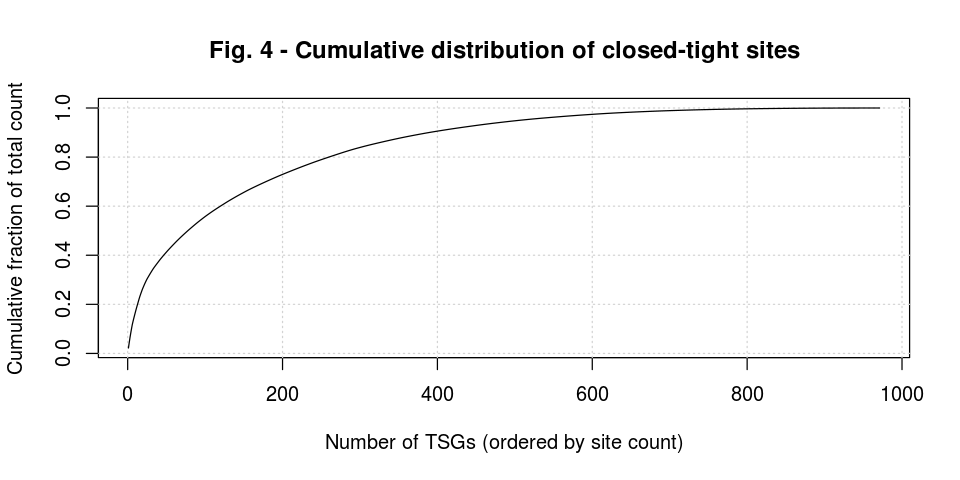

In [5]:
fracOfTotalSites <- nsites/sum(nsites)
fracOfTotalSites <- fracOfTotalSites[order(-fracOfTotalSites)]
cumuSum <- cumsum(fracOfTotalSites)
options(repr.plot.width=8, repr.plot.height=4)
plot(cumuSum,type="n",xlab="Number of TSGs (ordered by site count)",ylab="Cumulative fraction of total count")
grid()
lines(cumuSum)
title("Fig. 4 - Cumulative distribution of closed-tight sites")

In [7]:
cumuSum

PTPRD    CNTNAP2        DMD      LRP1B      CSMD1     CTNNA3       GPC5 
0.02204026 0.04379989 0.06438646 0.08318272 0.10117206 0.11802331 0.13140745 
     RBMS3       FHIT     CTNNA2      LSAMP      ROBO1      ERBB4      CADM2 
0.14422333 0.15661476 0.16871934 0.18059459 0.19181450 0.20290771 0.21383067 
      WWOX        DCC      PCDH9      RUNX1      CDH13     INPP4B      PTPRT 
0.22466501 0.23463801 0.24375823 0.25262968 0.26131301 0.26881550 0.27621615 
     OPCML   CACNA2D3      FOXP1     CAMTA1       CUX1      PTPRK       DLC1 
0.28354917 0.29028439 0.29699317 0.30312514 0.30873549 0.31410485 0.31946644 
     DLEU1     MAPK10      UNC5D    FAM172A      EGLN3      PACRG       TCF4 
0.32477516 0.32994318 0.33506611 0.34007943 0.34495671 0.34950127 0.35384605 
     DACH1     RASAL2    ALDH1A2     POU6F2       ESR1      PDSS2       GPC3 
0.35810220 0.36229072 0.36645981 0.37061956 0.37477077 0.37891964 0.38292859 
   L3MBTL4      KMT2C        NF1      PRKCE      UVRAG      SLIT2        MCC 
0.38679994 0.39064719 0.39443148 0.39818311 0.40184457 0.40546793 0.40908119 
     SSBP2      PRKCB      EPHA3      SASH1       ROR2      EPB41       RARB 
0.41269212 0.41630149 0.41985412 0.42329713 0.42668651 0.43007355 0.43344116 
     RFWD2     RNF111     PHLPP1     GRIN2A      GSK3B      UNC5C       DLG1 
0.43676756 0.44005510 0.44334108 0.44662473 0.44990139 0.45314384 0.45635208 
   SMARCC1      CADM1      BMPR2     NEDD4L     IQGAP2       THRB      PPM1L 
0.45951680 0.46261776 0.46570940 0.46879638 0.47183127 0.47483895 0.47779143 
      ESR2       EXT1       NUMB      KDM6A       RBM6      RUNX2      KANK1 
0.48074081 0.48366376 0.48656649 0.48945835 0.49231988 0.49517753 0.49802818 
   RPS6KA2      SGMS1      BASP1     RASSF3      NDST4       CDH4       TP63 
0.50084540 0.50361754 0.50635313 0.50907863 0.51177458 0.51446664 0.51715171 
     EFNA5     FBXL13     SRGAP3      RBBP8     HIVEP3      PLCE1        ST7 
0.51983367 0.52250397 0.52514939 0.52779015 0.53039748 0.53296594 0.53553285 
     ZFHX3      KIF1B       EYA4      NRCAM     TGFBR3      MCPH1    PHACTR4 
0.53803601 0.54053840 0.54302368 0.54548098 0.54793750 0.55036447 0.55278601 
     PDS5B     BMPR1A      FBXW7      SETD2      PBRM1      ARID2       CFTR 
0.55518811 0.55756145 0.55988426 0.56217987 0.56445370 0.56670344 0.56894229 
    ZBTB7C     PTPN13     TMEFF2      PTPRJ     LMNTD1     TCF7L2      UBE4B 
0.57117259 0.57339823 0.57558267 0.57775078 0.57991345 0.58203802 0.58414939 
     NUP98      NTRK3       CDK6    EPB41L3      EXTL3      NEDD4      PRDM5 
0.58624676 0.58833247 0.59040030 0.59246268 0.59452118 0.59654781 0.59856434 
     VPS53    SMARCA2      DLEU2     SMCHD1       ETV6     MYO18B     SYNPO2 
0.60057930 0.60259038 0.60459214 0.60658922 0.60858243 0.61057252 0.61255639 
      PLD1      RAP1A        RB1      BRCA1        ST5      PIAS1   ARHGEF12 
0.61452860 0.61648915 0.61844348 0.62037372 0.62224565 0.62410592 0.62596074 
      MSH2      FOXO1      DCDC2       RBL1    TSC22D1     RNF180     SPTBN1 
0.62781479 0.62966651 0.63150968 0.63335129 0.63517191 0.63698709 0.63877351 
   STARD13      LIMA1   ADAMTS18       NRF1        ATM      UIMC1     CREBBP 
0.64055838 0.64233624 0.64410478 0.64585311 0.64757734 0.64930156 0.65102190 
     ABCG2   PRICKLE1     BRINP1        APC      MOB1B       ABI2      MTUS1 
0.65273369 0.65444471 0.65615416 0.65785041 0.65954587 0.66123123 0.66288782 
     HACE1    PPP2R5C      HIPK2      STK10      CDC73        ATR        CBL 
0.66453198 0.66616370 0.66773867 0.66930742 0.67087462 0.67243793 0.67397792 
    TRIM24     RB1CC1       RTN4       PAWR      PPARG       YAP1     ANAPC1 
0.67550936 0.67703069 0.67854503 0.68005159 0.68155426 0.68305460 0.68455261 
      FAT4        MME      IKZF2       CUL5      MTSS1       CHFR     AKAP12 
0.68604285 0.68751443 0.68898135 0.69044126 0.69189574 0.69335022 0.69480003 
      ZHX2       SUFU      IFT88      DAPK1      ESRRB       CDH1       CTCF 
0.69624440 0.69768722 0.699

In [109]:
sum(tsgann[178,6])

[1] 2182

In [112]:
nsites <- rowSums(tsgann[,6])
quantile(nsites,c(0.845))

84.5% 
2181.65

In [130]:
tsg_EN_den <- rowSums(tsgann[,6])/tsgann$length
tsg_EN_den[178]

[1] 0.01572715

In [122]:
quantile(tsg_EN_den,c(0.841))

84.1% 
0.01572098

In [134]:
tmp<-cbind(tsgann$tsg_name,tsgann$CT,tsg_EN_den)
colnames(tmp)<-c('TSG Name','CT Site Count','CT Site Density')
tmp<-tmp[order(-tsgann$CT),]

In [135]:
write.csv(tmp, file="GeneList.csv")